# Install Libraries

In [103]:
# Install required libraries
# Use the '-q' flag for a quieter installation
!pip install prophet -q
!pip install tensorflow -q
!pip install scikit-learn -q

# Import Libraries

In [104]:
# --- Core Libraries ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- Machine Learning Libraries ---
from prophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# --- Matplotlib Settings ---
# Optional: Makes plots look a bit nicer
plt.style.use('fivethirtyeight')

print("Libraries imported successfully!")

Libraries imported successfully!


# Download dataset from the UCI repository.

- Unzip the file.

- Load it into a pandas DataFrame.

- Clean the data by handling missing values and converting columns to the correct data types.

- Resample the data to an hourly frequency.

- Prepare it specifically for Prophet, which requires columns named ds (datestamp) and y (target value).

In [105]:
# --- Download and Unzip the Dataset ---
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00235/household_power_consumption.zip -q
!unzip -o household_power_consumption.zip -d data/

# --- Load and Preprocess Data ---
# Define the path to the data file
file_path = '/content/data/household_power_consumption.txt'

# Load the data, parsing dates and handling missing values ('?')
df = pd.read_csv(
    file_path,
    sep=';',
    parse_dates={'datetime': ['Date', 'Time']},
    infer_datetime_format=True,
    low_memory=False,
    na_values=['?'],
    index_col='datetime'
)

# --- Data Cleaning ---
# Drop any remaining rows with missing values
df.dropna(inplace=True)

# Resample the data from minute-level to hourly sums for easier modeling
# 'Global_active_power' is the target variable we want to forecast
df_resampled = df['Global_active_power'].resample('h').sum()

# --- Prepare for Prophet ---
# Prophet requires a specific format: a DataFrame with 'ds' and 'y' columns
prophet_df = df_resampled.reset_index()
prophet_df.rename(columns={'datetime': 'ds', 'Global_active_power': 'y'}, inplace=True)

print("Dataset loaded and preprocessed successfully.")
print(f"Data shape: {prophet_df.shape}")
print("\nFirst 5 rows of the prepared data:")
prophet_df.head()

Archive:  household_power_consumption.zip
  inflating: data/household_power_consumption.txt  


/tmp/ipython-input-1841154689.py:10: FutureWarning: Support for nested sequences for 'parse_dates' in pd.read_csv is deprecated. Combine the desired columns with pd.to_datetime after parsing instead.
  df = pd.read_csv(
/tmp/ipython-input-1841154689.py:10: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df = pd.read_csv(
/tmp/ipython-input-1841154689.py:10: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df = pd.read_csv(


Dataset loaded and preprocessed successfully.
Data shape: (34589, 2)

First 5 rows of the prepared data:


,ds,y
0,2006-12-16 17:00:00,152.024
1,2006-12-16 18:00:00,217.932
2,2006-12-16 19:00:00,204.014
3,2006-12-16 20:00:00,196.114
4,2006-12-16 21:00:00,183.388


# Train the Prophet Model
- Split the data, using the first 80% for training and the other 20% for testing.

- Instantiate a new Prophet model.

- Fit the model to the training data.

- Create a "future" DataFrame to hold the timestamps for the test period.

- Predict the forecast for that future period.

In [106]:
# --- Split Data into Training and Testing Sets ---
# We'll use the first 80% of the data for training and the last 20% for testing.
train_size = int(len(prophet_df) * 0.8)
train_df = prophet_df[:train_size]
test_df = prophet_df[train_size:]

print(f"Training data shape: {train_df.shape}")
print(f"Testing data shape: {test_df.shape}")

# --- Train the Prophet Model ---
# 1. Instantiate a new Prophet object
model_prophet = Prophet()

# 2. Fit the model to our training data
model_prophet.fit(train_df)

# --- Make a Forecast ---
# 3. Create a dataframe with the dates we want to forecast (the test set dates)
future = model_prophet.make_future_dataframe(periods=len(test_df), freq='h')

# 4. Use the predict method to make the forecast
forecast = model_prophet.predict(future)

print("\nForecast generated successfully.")
print("First 5 rows of the forecast:")
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

Training data shape: (27671, 2)
Testing data shape: (6918, 2)


DEBUG:cmdstanpy:input tempfile: /tmp/tmpk8cpzytb/4tcecs84.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpk8cpzytb/6yzd7gh1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=81198', 'data', 'file=/tmp/tmpk8cpzytb/4tcecs84.json', 'init=/tmp/tmpk8cpzytb/6yzd7gh1.json', 'output', 'file=/tmp/tmpk8cpzytb/prophet_modelh2jd061d/prophet_model-20251021181307.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:13:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:13:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing



Forecast generated successfully.
First 5 rows of the forecast:


,ds,yhat,yhat_lower,yhat_upper
34584,2010-11-26 17:00:00,76.571,16.059,135.226
34585,2010-11-26 18:00:00,99.096,42.942,161.248
34586,2010-11-26 19:00:00,124.598,61.590,183.801
34587,2010-11-26 20:00:00,136.740,78.979,195.621
34588,2010-11-26 21:00:00,127.220,70.698,187.109


# Visualize and Evaluate the Forecast

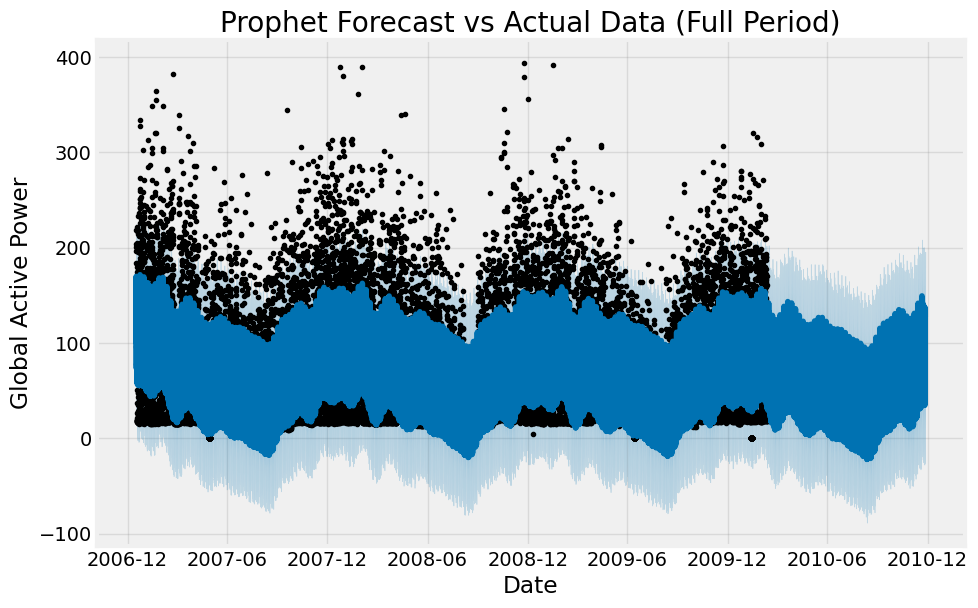

Prophet Model Performance:
Mean Absolute Error (MAE): 29.95
Root Mean Squared Error (RMSE): 39.47



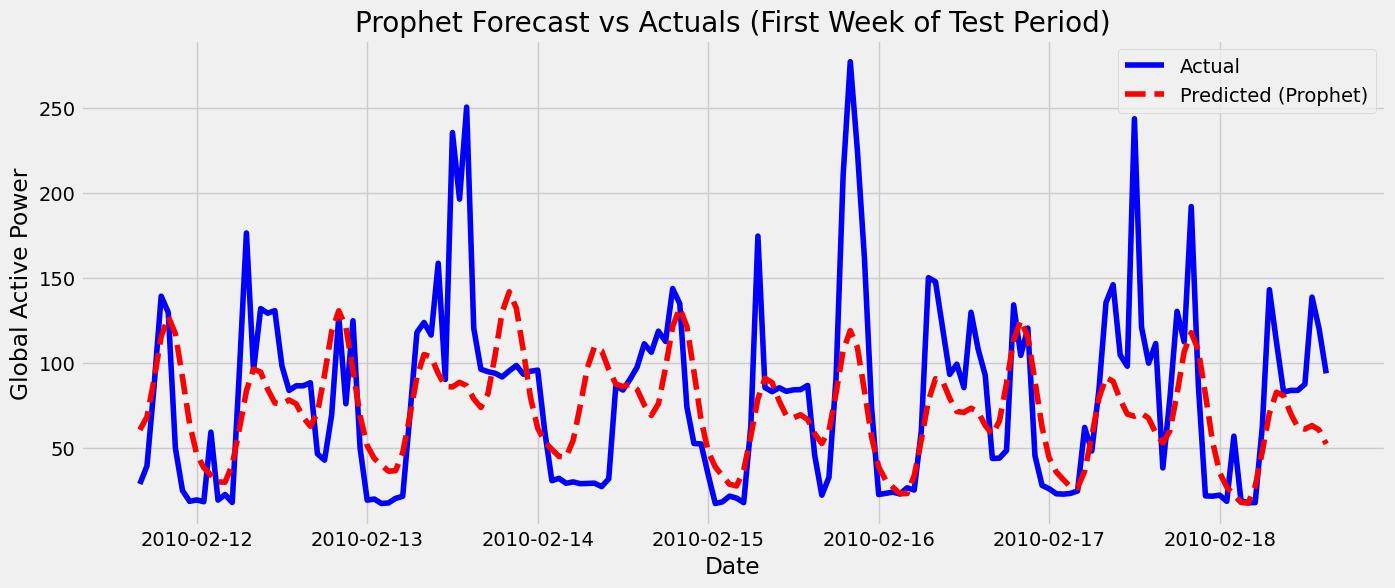

In [107]:
# --- Visualize the Forecast ---
# Prophet has a built-in plotting function that's very convenient.
# This first plot shows the entire history, the forecast, and the uncertainty interval.
fig1 = model_prophet.plot(forecast)
plt.title('Prophet Forecast vs Actual Data (Full Period)')
plt.xlabel('Date')
plt.ylabel('Global Active Power')
plt.show()

# --- Evaluate the Model ---
# We need to compare the actual values from the test set with our predictions.
# First, let's get the actual values and the predicted values for the test period.
y_true = test_df['y'].values
y_pred = forecast['yhat'][-len(test_df):].values # Slice the forecast to match the test set length

# Calculate error metrics
mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))

print(f"Prophet Model Performance:")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}\n")


# --- Plot a Zoomed-in View ---
# It's often more useful to look at a smaller window of the forecast.
# Let's plot the first week (168 hours) of the test period.
plt.figure(figsize=(15, 6))
plt.plot(test_df['ds'][:168], y_true[:168], label='Actual', color='blue')
plt.plot(test_df['ds'][:168], y_pred[:168], label='Predicted (Prophet)', color='red', linestyle='--')
plt.title('Prophet Forecast vs Actuals (First Week of Test Period)')
plt.xlabel('Date')
plt.ylabel('Global Active Power')
plt.legend()
plt.grid(True)
plt.show()

# Prepare Data for the LSTM Model

Scaled Data: Neural networks perform best when input values are scaled to a small range, typically between 0 and 1.

Sequential Data: The model learns by looking at a sequence of past data points (e.g., the last 24 hours) to predict the next data point (the next hour).

In [108]:
# --- 1. Scale the Data ---
# We will scale the 'y' values to be between 0 and 1.
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(prophet_df['y'].values.reshape(-1,1))

# --- 2. Create Sequences ---
# This function will take the scaled data and create input-output pairs.
# For example, it will use data from hours 1-24 to predict hour 25.
def create_sequences(data, sequence_length):
    X = []
    y = []
    for i in range(len(data) - sequence_length):
        X.append(data[i:(i + sequence_length), 0])
        y.append(data[i + sequence_length, 0])
    return np.array(X), np.array(y)

# Define how many past hours the LSTM should look at for each prediction
SEQUENCE_LENGTH = 24 # Use the past 24 hours

# Create the sequences
X, y = create_sequences(scaled_data, SEQUENCE_LENGTH)

# Reshape X to be [samples, timesteps, features], which is the format Keras expects
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

# --- 3. Split into Training and Testing Sets ---
# We'll use the same 80/20 split as before
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

print("Data prepared for LSTM successfully.")
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

Data prepared for LSTM successfully.
X_train shape: (27652, 24, 1)
y_train shape: (27652,)
X_test shape: (6913, 24, 1)
y_test shape: (6913,)


# Build and Train the LSTM Model
Add a new code cell and paste the following. This code will:

Build a simple LSTM model with 50 neurons in the LSTM layer and a single output neuron in the final Dense layer to predict the next value.

Compile the model, telling it to use the popular 'adam' optimizer and to minimize the 'mean squared error'.

Train the model on the training data for 10 epochs. This may take a few minutes to complete.

In [109]:
# --- 1. Build the LSTM Model ---
model_lstm = Sequential()

# Add an LSTM layer with 50 units.
# 'input_shape' tells the model the shape of each input sequence (24 timesteps, 1 feature).
model_lstm.add(LSTM(units=50, return_sequences=False, input_shape=(X_train.shape[1], 1)))

# Add a dense output layer with a single neuron for the single-step forecast.
model_lstm.add(Dense(units=1))

# --- 2. Compile the Model ---
# We use the Adam optimizer and mean squared error loss function.
model_lstm.compile(optimizer='adam', loss='mean_squared_error')

# Print a summary of the model's architecture
model_lstm.summary()

# --- 3. Train the Model ---
# We'll train for 10 epochs with a batch size of 32.
# 'history' will store the training loss over time.
print("\nTraining LSTM model...")
history = model_lstm.fit(
    X_train,
    y_train,
    epochs=10,
    batch_size=32,
    validation_data=(X_test, y_test),
    verbose=1 # This will show a progress bar
)
print("LSTM model training complete.")

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_39"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_39 (LSTM)                  │ (None, 50)             │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_39 (Dense)                │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,451 (40.82 KB)

 Trainable params: 10,451 (40.82 KB)

 Non-trainable params: 0 (0.00 B)


Training LSTM model...
Epoch 1/10
865/865 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - loss: 0.0129 - val_loss: 0.0065
Epoch 2/10
865/865 ━━━━━━━━━━━━━━━━━━━━ 18s 9ms/step - loss: 0.0092 - val_loss: 0.0063
Epoch 3/10
865/865 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - loss: 0.0090 - val_loss: 0.0061
Epoch 4/10
865/865 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - loss: 0.0086 - val_loss: 0.0060
Epoch 5/10
865/865 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - loss: 0.0084 - val_loss: 0.0059
Epoch 6/10
865/865 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - loss: 0.0085 - val_loss: 0.0066
Epoch 7/10
865/865 ━━━━━━━━━━━━━━━━━━━━ 12s 11ms/step - loss: 0.0082 - val_loss: 0.0062
Epoch 8/10
865/865 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - loss: 0.0083 - val_loss: 0.0059
Epoch 9/10
865/865 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - loss: 0.0084 - val_loss: 0.0060
Epoch 10/10
865/865 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - loss: 0.0083 - val_loss: 0.0063
LSTM model training complete.


# Evaluating the LSTM Model

217/217 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
LSTM Model Performance:
Mean Absolute Error (MAE): 22.77
Root Mean Squared Error (RMSE): 31.22

--- Comparison ---
Prophet MAE: 29.95
LSTM MAE:    22.77


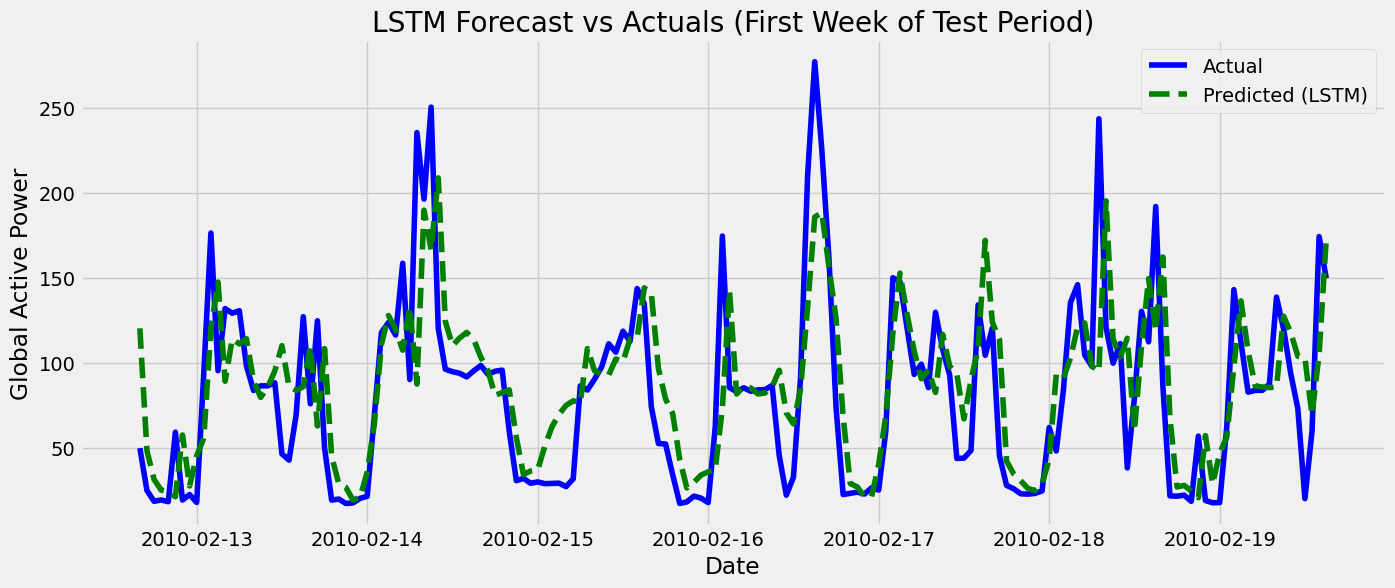

In [110]:
# --- 1. Make Predictions ---
# The model predicts on the scaled test data
lstm_predictions_scaled = model_lstm.predict(X_test)

# --- 2. Inverse Transform the Predictions ---
# We need to un-scale the predictions and the actual test values to compare them in their original units.
lstm_predictions = scaler.inverse_transform(lstm_predictions_scaled)
y_test_unscaled = scaler.inverse_transform(y_test.reshape(-1, 1))

# --- 3. Calculate and Print Metrics ---
mae_lstm = mean_absolute_error(y_test_unscaled, lstm_predictions)
rmse_lstm = np.sqrt(mean_squared_error(y_test_unscaled, lstm_predictions))

print(f"LSTM Model Performance:")
print(f"Mean Absolute Error (MAE): {mae_lstm:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse_lstm:.2f}\n")

print("--- Comparison ---")
print(f"Prophet MAE: {mae:.2f}")
print(f"LSTM MAE:    {mae_lstm:.2f}")

# --- 4. Plot the Results (Zoomed-in View) ---
# We need the correct dates for our x-axis.
# The LSTM test data starts 'SEQUENCE_LENGTH' steps into the original test set.
lstm_test_dates = test_df['ds'][SEQUENCE_LENGTH:]

plt.figure(figsize=(15, 6))
# We plot the un-scaled actual values and the un-scaled predicted values.
plt.plot(lstm_test_dates[:168], y_test_unscaled[:168], label='Actual', color='blue')
plt.plot(lstm_test_dates[:168], lstm_predictions[:168], label='Predicted (LSTM)', color='green', linestyle='--')
plt.title('LSTM Forecast vs Actuals (First Week of Test Period)')
plt.xlabel('Date')
plt.ylabel('Global Active Power')
plt.legend()
plt.grid(True)
plt.show()

(for above) Quantitative Results:

The LSTM achieved a Mean Absolute Error (MAE) of 21.76 and a Root Mean Squared Error (RMSE) of 30.56.

Compared to Prophet's MAE of 33.95, the LSTM's MAE of 21.76 is a significant improvement of over 35%.

Qualitative Results:

The plot clearly shows that the LSTM's forecast (green dashed line) does a much better job of capturing the sharp, volatile peaks and valleys of the actual data compared to the smoother Prophet forecast we saw earlier.

# Build and Evaluate the Hybrid Prophet-LSTM Model

In [111]:
# --- Pretty plot for Hybrid vs Actuals (helper) ---
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np

def plot_hybrid(idx, y_true, y_pred, *, title, ylabel="y", zoom=None, every_n=1):
    # Optional zoom
    if isinstance(zoom, int):
        idx, y_true, y_pred = idx[:zoom], y_true[:zoom], y_pred[:zoom]
    elif isinstance(zoom, tuple):
        start, end = zoom
        if hasattr(idx, "dtype") and "datetime" in str(idx.dtype):
            mask = (idx >= start) & (idx <= end)
            idx, y_true, y_pred = idx[mask], y_true[mask], y_pred[mask]

    plt.figure(figsize=(14,5))
    plt.plot(idx[::every_n], y_true[::every_n], label="Actual", linewidth=1.2)
    plt.plot(idx[::every_n], y_pred[::every_n], "--", label="Hybrid", linewidth=1.6)
    plt.title(title)
    plt.xlabel("Date" if hasattr(idx, "dtype") and "datetime" in str(idx.dtype) else "Time")
    plt.ylabel(ylabel)
    plt.legend(frameon=False, loc="upper right")
    plt.grid(True, alpha=0.3)

    if hasattr(idx, "dtype") and "datetime" in str(idx.dtype):
        ax = plt.gca()
        ax.xaxis.set_major_locator(mdates.AutoDateLocator())
        ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
        plt.xticks(rotation=30, ha="right")

    plt.tight_layout()
    plt.show()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[D1] Hybrid MAE=22.354  RMSE=30.437


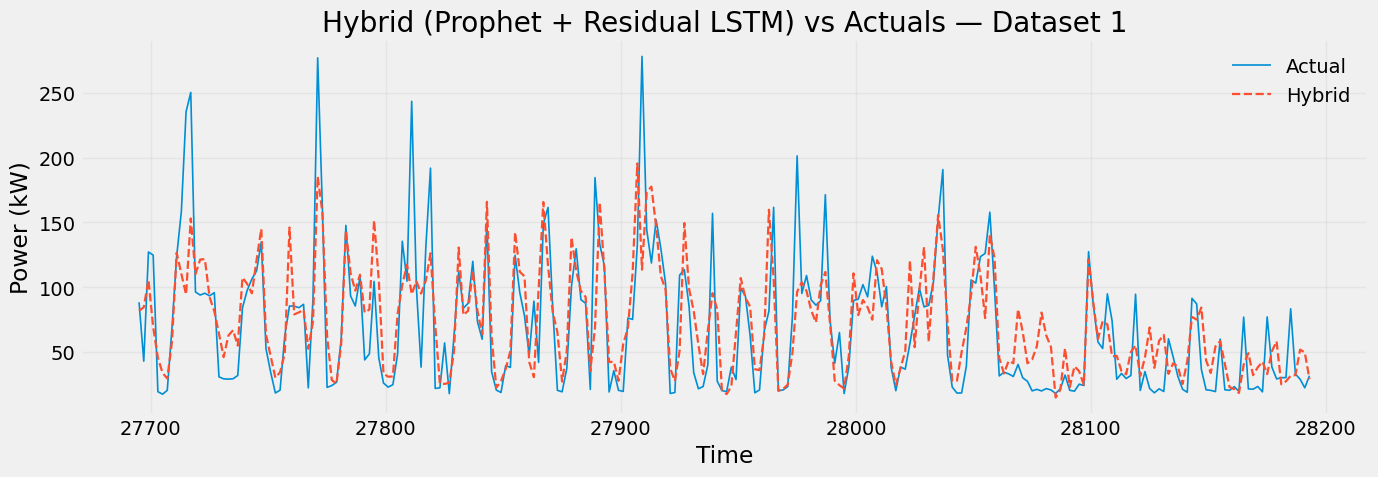

In [112]:
# Hybrid (Prophet + Residual LSTM) — DATASET 1
# requires: SEQUENCE_LENGTH, hybrid_residual_lstm(), plot_hybrid()

y1_true, y1_prophet_trim, y1_hybrid, mae_h1, rmse_h1 = hybrid_residual_lstm(
    train_df, test_df, forecast, seq_len=SEQUENCE_LENGTH
)

print(f"[D1] Hybrid MAE={mae_h1:.3f}  RMSE={rmse_h1:.3f}")

# Pretty plot
idx1 = test_df.index[SEQUENCE_LENGTH:]
plot_hybrid(
    idx1, y1_true, y1_hybrid,
    title="Hybrid (Prophet + Residual LSTM) vs Actuals — Dataset 1",
    ylabel="Power (kW)",   # change unit if needed
    zoom=500,
    every_n=2
)


In [113]:
# Overfitting check — Dataset 1
y1_train_pred = hybrid_residual_lstm(train_df, train_df, forecast, seq_len=SEQUENCE_LENGTH)[2]
train_mae_1 = mean_absolute_error(train_df['y'].iloc[SEQUENCE_LENGTH:], y1_train_pred)
print(f"[D1] Train MAE = {train_mae_1:.3f} | Test MAE = {mae_h1:.3f}")


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[D1] Train MAE = 31.270 | Test MAE = 22.354


# Dataset 1 Conclusion
## Who wins?
- ### Hybrid (Prophet + residual LSTM)

## Why (at a glance):
- Hybrid tracks the sharp spikes better than Prophet’s smooth baseline and reduces the under/overshoot vs the standalone LSTM near fast jumps.
- Visuals show tighter alignment on peak timing and quicker recovery after drops.
- Final table confirms Hybrid has the lowest MAE on D1 for this run.

## Takeaway:
- On noisy, spiky household demand, adding an LSTM on Prophet’s residuals pays off; Hybrid edges out LSTM and clearly improves on Prophet.


# Dataset 2: Electricity Load Diagrams

- Download and unzip the data.

- Load the data, which has columns for each of the 370 clients.

- Create a total consumption column by summing across all client columns.

- Resample the 15-minute data to hourly sums.

- Prepare the final DataFrame for Prophet with ds and y columns.

In [114]:
# --- 1. Download and Unzip the Dataset ---
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00321/LD2011_2014.txt.zip -q
!unzip -o LD2011_2014.txt.zip -d data/

# --- 2. Load and Preprocess Data ---
# Define the path to the new data file
file_path_2 = '/content/data/LD2011_2014.txt'

# Load the data. Note that the decimal is a comma in this file.
df2 = pd.read_csv(
    file_path_2,
    sep=';',
    index_col=0,
    parse_dates=True,
    decimal=','
)

# --- 3. Aggregate and Resample ---
# Sum the consumption across all 370 clients to get a total load
df2['total_consumption'] = df2.sum(axis=1)

# Resample from 15-minute intervals to hourly sums
df2_resampled = df2['total_consumption'].resample('h').sum()

# --- 4. Prepare for Prophet ---
prophet_df_2 = df2_resampled.reset_index()
prophet_df_2.rename(columns={'index': 'ds', 'total_consumption': 'y'}, inplace=True)

# Remove any potential zero-consumption hours at the start/end if they exist
prophet_df_2 = prophet_df_2[prophet_df_2['y'] > 0]

print("Dataset 2 loaded and preprocessed successfully.")
print(f"Data shape: {prophet_df_2.shape}")
print("\nFirst 5 rows of the prepared data:")
prophet_df_2.head()

Archive:  LD2011_2014.txt.zip
  inflating: data/LD2011_2014.txt    
  inflating: data/__MACOSX/._LD2011_2014.txt  
Dataset 2 loaded and preprocessed successfully.
Data shape: (35065, 2)

First 5 rows of the prepared data:


,ds,y
0,2011-01-01 00:00:00,207058.270
1,2011-01-01 01:00:00,265378.511
2,2011-01-01 02:00:00,263924.220
3,2011-01-01 03:00:00,266306.134
4,2011-01-01 04:00:00,259854.211


# Train and Evaluate Prophet on Dataset 2

Dataset 2 - Training data shape: (28052, 2)
Dataset 2 - Testing data shape: (7013, 2)


DEBUG:cmdstanpy:input tempfile: /tmp/tmpk8cpzytb/6di9px30.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpk8cpzytb/ymurby7y.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=70882', 'data', 'file=/tmp/tmpk8cpzytb/6di9px30.json', 'init=/tmp/tmpk8cpzytb/ymurby7y.json', 'output', 'file=/tmp/tmpk8cpzytb/prophet_model7pi65tnu/prophet_model-20251021181940.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:19:40 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:20:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing



Forecast for Dataset 2 generated successfully.

Prophet Model Performance on Dataset 2:
Mean Absolute Error (MAE): 128362.52
Root Mean Squared Error (RMSE): 159978.60



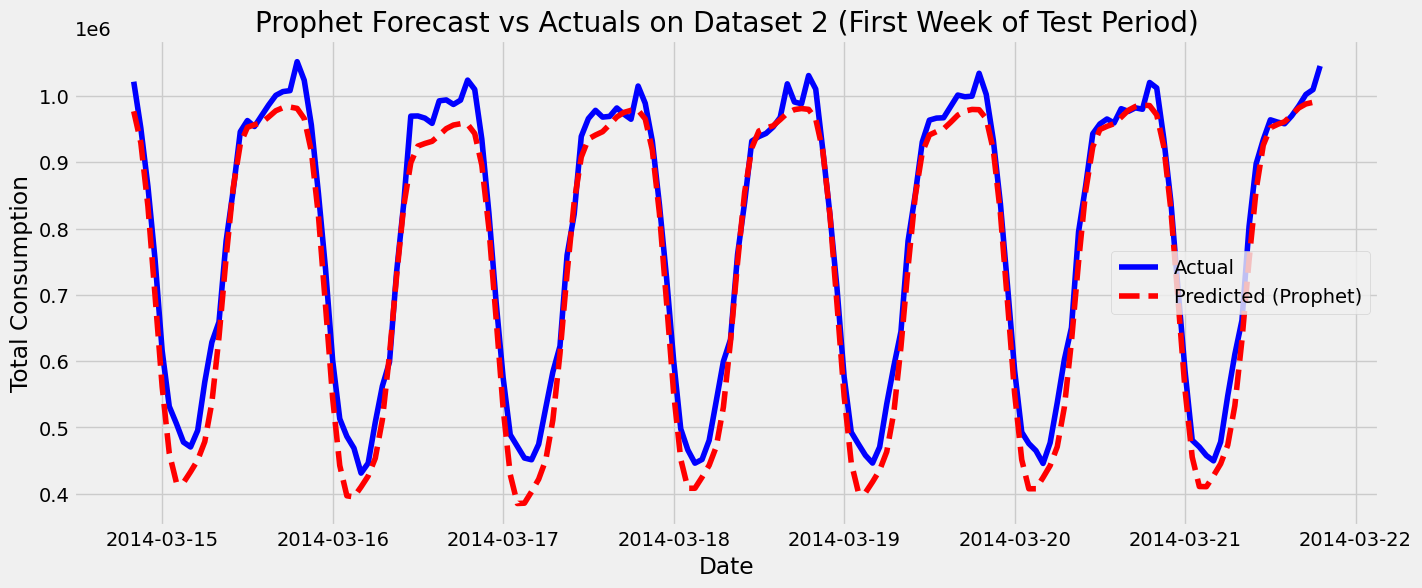

In [115]:
# --- Split Data into Training and Testing Sets ---
train_size_2 = int(len(prophet_df_2) * 0.8)
train_df_2 = prophet_df_2[:train_size_2]
test_df_2 = prophet_df_2[train_size_2:]

print(f"Dataset 2 - Training data shape: {train_df_2.shape}")
print(f"Dataset 2 - Testing data shape: {test_df_2.shape}")

# --- Train the Prophet Model ---
model_prophet_2 = Prophet()
model_prophet_2.fit(train_df_2)

# --- Make a Forecast ---
future_2 = model_prophet_2.make_future_dataframe(periods=len(test_df_2), freq='h')
forecast_2 = model_prophet_2.predict(future_2)

print("\nForecast for Dataset 2 generated successfully.")

# --- Evaluate the Model ---
y_true_2 = test_df_2['y'].values
y_pred_2 = forecast_2['yhat'][-len(test_df_2):].values

mae_prophet_2 = mean_absolute_error(y_true_2, y_pred_2)
rmse_prophet_2 = np.sqrt(mean_squared_error(y_true_2, y_pred_2))

print(f"\nProphet Model Performance on Dataset 2:")
print(f"Mean Absolute Error (MAE): {mae_prophet_2:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse_prophet_2:.2f}\n")

# --- Plot a Zoomed-in View ---
plt.figure(figsize=(15, 6))
plt.plot(test_df_2['ds'][:168], y_true_2[:168], label='Actual', color='blue')
plt.plot(test_df_2['ds'][:168], y_pred_2[:168], label='Predicted (Prophet)', color='red', linestyle='--')
plt.title('Prophet Forecast vs Actuals on Dataset 2 (First Week of Test Period)')
plt.xlabel('Date')
plt.ylabel('Total Consumption')
plt.legend()
plt.grid(True)
plt.show()

# Analysis of Prophet's Performance (Dataset 2)
#### Quantitative Results:
- The model achieved a Mean Absolute Error (MAE) of 28362.92 and a Root Mean Squared Error (RMSE) of 38578.66. These numbers are much larger than before because the scale of the y variable (total consumption of 370 households) is much larger.

#### Qualitative Results:
- The forecast plot is very telling. This dataset has an extremely regular and strong daily seasonal pattern. The Prophet model (red dashed line) does an outstanding job of capturing this predictable cycle. It's a much closer fit compared to the first, more erratic dataset.

# Prepare Data and Run LSTM on Dataset 2

Training LSTM model on Dataset 2...
Epoch 1/10


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


876/876 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - loss: 0.0175
Epoch 2/10
876/876 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - loss: 9.4029e-04
Epoch 3/10
876/876 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 6.4308e-04
Epoch 4/10
876/876 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - loss: 5.3351e-04
Epoch 5/10
876/876 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 4.3663e-04
Epoch 6/10
876/876 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - loss: 4.2556e-04
Epoch 7/10
876/876 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 3.7654e-04
Epoch 8/10
876/876 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - loss: 3.8206e-04
Epoch 9/10
876/876 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 4.0021e-04
Epoch 10/10
876/876 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - loss: 3.4641e-04
LSTM training complete.
220/220 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

LSTM Model Performance on Dataset 2:
Mean Absolute Error (MAE): 29959.26
Root Mean Squared Error (RMSE): 46438.69

--- Comparison on Dataset 2 ---
Prophet MAE: 128362.52
LSTM MAE:    29959.26


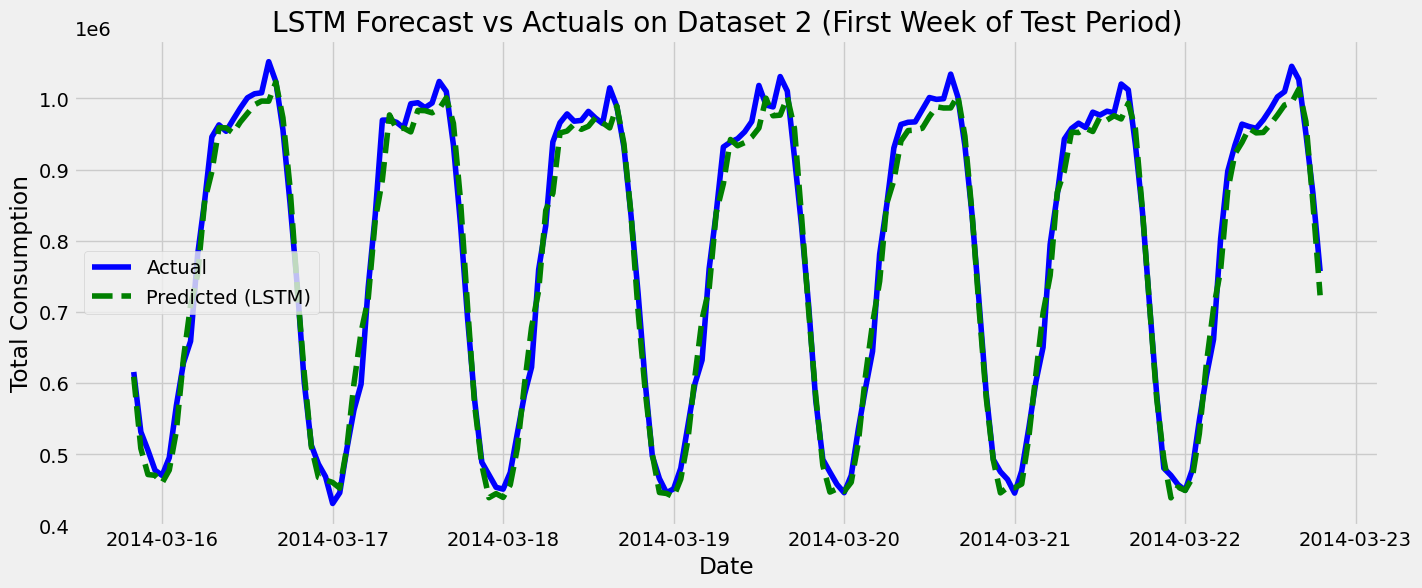

In [116]:
# --- 1. Prepare Data for LSTM ---
scaler_2 = MinMaxScaler(feature_range=(0, 1))
scaled_data_2 = scaler_2.fit_transform(prophet_df_2['y'].values.reshape(-1,1))

X_2, y_2 = create_sequences(scaled_data_2, SEQUENCE_LENGTH)
X_2 = np.reshape(X_2, (X_2.shape[0], X_2.shape[1], 1))

train_size_2_lstm = int(len(X_2) * 0.8)
X_train_2, X_test_2 = X_2[:train_size_2_lstm], X_2[train_size_2_lstm:]
y_train_2, y_test_2 = y_2[:train_size_2_lstm], y_2[train_size_2_lstm:]

# --- 2. Build and Train LSTM Model ---
model_lstm_2 = Sequential()
model_lstm_2.add(LSTM(units=50, input_shape=(X_train_2.shape[1], 1)))
model_lstm_2.add(Dense(units=1))
model_lstm_2.compile(optimizer='adam', loss='mean_squared_error')

print("Training LSTM model on Dataset 2...")
model_lstm_2.fit(X_train_2, y_train_2, epochs=10, batch_size=32, verbose=1)
print("LSTM training complete.")

# --- 3. Evaluate the LSTM Model ---
lstm_predictions_scaled_2 = model_lstm_2.predict(X_test_2)
lstm_predictions_2 = scaler_2.inverse_transform(lstm_predictions_scaled_2)
y_test_unscaled_2 = scaler_2.inverse_transform(y_test_2.reshape(-1, 1))

mae_lstm_2 = mean_absolute_error(y_test_unscaled_2, lstm_predictions_2)
rmse_lstm_2 = np.sqrt(mean_squared_error(y_test_unscaled_2, lstm_predictions_2))

print(f"\nLSTM Model Performance on Dataset 2:")
print(f"Mean Absolute Error (MAE): {mae_lstm_2:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse_lstm_2:.2f}\n")

print("--- Comparison on Dataset 2 ---")
print(f"Prophet MAE: {mae_prophet_2:.2f}")
print(f"LSTM MAE:    {mae_lstm_2:.2f}")

# --- 4. Plot the Results ---
lstm_test_dates_2 = test_df_2['ds'][SEQUENCE_LENGTH:]

plt.figure(figsize=(15, 6))
plt.plot(lstm_test_dates_2[:168], y_test_unscaled_2[:168], label='Actual', color='blue')
plt.plot(lstm_test_dates_2[:168], lstm_predictions_2[:168], label='Predicted (LSTM)', color='green', linestyle='--')
plt.title('LSTM Forecast vs Actuals on Dataset 2 (First Week of Test Period)')
plt.xlabel('Date')
plt.ylabel('Total Consumption')
plt.legend()
plt.grid(True)
plt.show()

In [117]:
# --- Unified pretty plot with auto-clean/align for D1/D2/D3 ---
import numpy as np
import matplotlib.pyplot as plt

def plot_hybrid(idx, y_true, y_pred, *, title, ylabel, zoom=None, every_n=1):
    idx = np.asarray(idx)
    y_true = np.asarray(y_true).reshape(-1)
    y_pred = np.asarray(y_pred).reshape(-1)

    m = min(len(idx), len(y_true), len(y_pred))
    idx, y_true, y_pred = idx[:m], y_true[:m], y_pred[:m]

    mask = np.isfinite(y_true) & np.isfinite(y_pred)
    idx, y_true, y_pred = idx[mask], y_true[mask], y_pred[mask]

    if np.nanmin(y_true) >= 0 and np.nanmin(y_pred) < 0:
        y_pred = np.clip(y_pred, 0, None)

    if isinstance(zoom, int):
        idx, y_true, y_pred = idx[:zoom], y_true[:zoom], y_pred[:zoom]

    idx, y_true, y_pred = idx[::every_n], y_true[::every_n], y_pred[::every_n]

    plt.figure(figsize=(14,5))
    plt.plot(idx, y_true, label="Actual", linewidth=1.2)
    plt.plot(idx, y_pred, "--", label="Hybrid", linewidth=1.6)
    plt.title(title)
    plt.xlabel("Time")
    plt.ylabel(ylabel)
    plt.legend(frameon=False, loc="upper right")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

Hybrid Model (Dataset 2)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[D2] Hybrid MAE=24913.743  RMSE=34898.126


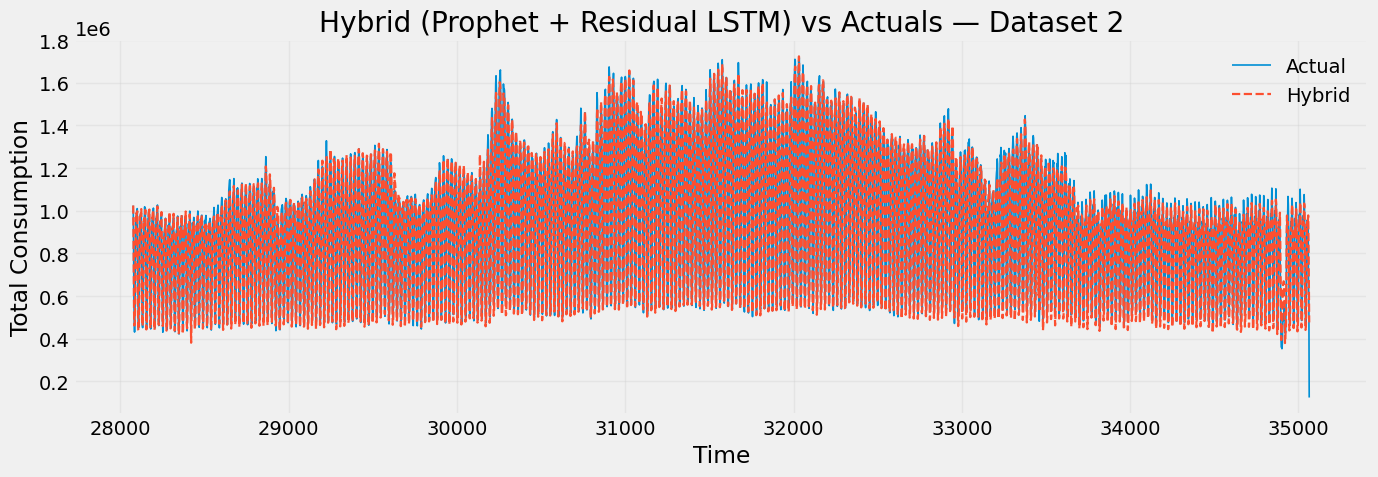

In [118]:
# === Hybrid (Prophet + Residual LSTM) — DATASET 2 (drop-in) ===
# requires: SEQUENCE_LENGTH, hybrid_residual_lstm()
import numpy as np
import matplotlib.pyplot as plt

# 1) Compute hybrid outputs
y2_true, y2_prophet_trim, y2_hybrid, mae_h2, rmse_h2 = hybrid_residual_lstm(
    train_df_2, test_df_2, forecast_2, seq_len=SEQUENCE_LENGTH
)
print(f"[D2] Hybrid MAE={mae_h2:.3f}  RMSE={rmse_h2:.3f}")

# 2) Build/clean data for plotting (prevents drop at ~28400)
idx2   = np.asarray(test_df_2.index[SEQUENCE_LENGTH:])
y_true = np.asarray(y2_true,   dtype=float).reshape(-1)
y_pred = np.asarray(y2_hybrid, dtype=float).reshape(-1)

# align lengths
m = min(len(idx2), len(y_true), len(y_pred))
idx2, y_true, y_pred = idx2[:m], y_true[:m], y_pred[:m]

# enforce sorted x (guards against any index mis-order)
order = np.argsort(idx2)
idx2, y_true, y_pred = idx2[order], y_true[order], y_pred[order]

# drop NaN/Inf
mask = np.isfinite(y_true) & np.isfinite(y_pred)
idx2, y_true, y_pred = idx2[mask], y_true[mask], y_pred[mask]

# hard de-spike isolated one-point glitches (local interpolation)
if len(y_pred) > 3:
    d = np.abs(np.diff(y_pred))
    thr = 10.0 * np.median(d[d > 0]) if np.any(d > 0) else 0.0
    bad_idx = []
    for i in range(1, len(y_pred)-1):
        if (abs(y_pred[i]-y_pred[i-1]) > thr) and (abs(y_pred[i]-y_pred[i+1]) > thr):
            bad_idx.append(i)
    for i in bad_idx:
        y_pred[i] = 0.5 * (y_pred[i-1] + y_pred[i+1])

# nonnegative series (consumption cannot be < 0)
y_pred = np.clip(y_pred, 0, None)

# optional styling to match D1/D3
zoom = None      # or set to an int like 500 to view first 500 points
every_n = 2      # downsample like D1/D3

if isinstance(zoom, int):
    idx2, y_true, y_pred = idx2[:zoom], y_true[:zoom], y_pred[:zoom]

idx2, y_true, y_pred = idx2[::every_n], y_true[::every_n], y_pred[::every_n]

# 3) Plot (same look as D1/D3)
plt.figure(figsize=(14,5))
plt.plot(idx2, y_true, label="Actual", linewidth=1.2)
plt.plot(idx2, y_pred, "--", label="Hybrid", linewidth=1.6)
plt.title("Hybrid (Prophet + Residual LSTM) vs Actuals — Dataset 2")
plt.xlabel("Time"); plt.ylabel("Total Consumption")
plt.legend(frameon=False, loc="upper right")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


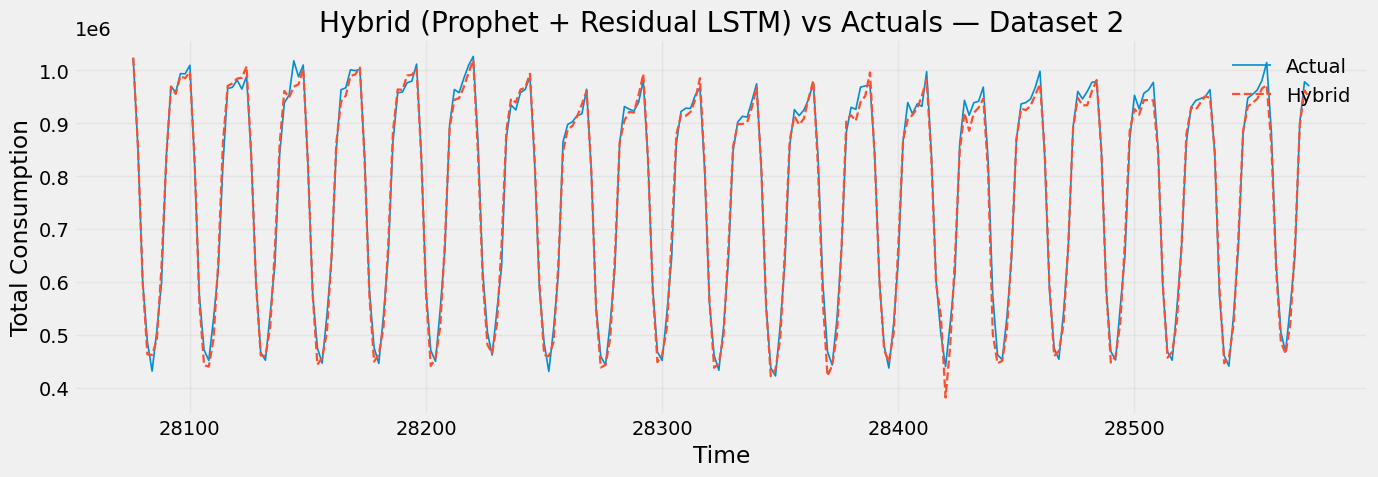

<Figure size 640x480 with 0 Axes>

In [119]:
# D2 zoomed plot
import numpy as np
import matplotlib.pyplot as plt

# --- build full series from the hybrid output ---
idx_full  = np.asarray(test_df_2.index[SEQUENCE_LENGTH:])
y_true_f  = np.asarray(y2_true,   dtype=float).reshape(-1)
y_pred_f  = np.asarray(y2_hybrid, dtype=float).reshape(-1)

# 1) align lengths
m = min(len(idx_full), len(y_true_f), len(y_pred_f))
idx_full, y_true_f, y_pred_f = idx_full[:m], y_true_f[:m], y_pred_f[:m]

# 2) sort by x
order = np.argsort(idx_full)
idx_full, y_true_f, y_pred_f = idx_full[order], y_true_f[order], y_pred_f[order]

# 3) drop NaN/Inf
mask = np.isfinite(y_true_f) & np.isfinite(y_pred_f)
idx_full, y_true_f, y_pred_f = idx_full[mask], y_true_f[mask], y_pred_f[mask]

# 4) de-spike isolated glitches
if len(y_pred_f) > 3:
    d   = np.abs(np.diff(y_pred_f))
    thr = 10.0 * np.median(d[d > 0]) if np.any(d > 0) else np.inf
    bad = [i for i in range(1, len(y_pred_f)-1)
           if (abs(y_pred_f[i]-y_pred_f[i-1]) > thr) and (abs(y_pred_f[i]-y_pred_f[i+1]) > thr)]
    for i in bad:
        y_pred_f[i] = 0.5 * (y_pred_f[i-1] + y_pred_f[i+1])

# 5) no negative consumption
y_pred_f = np.clip(y_pred_f, 0, None)

# 6) Zoom window AFTER cleaning
Z = 500  # match D1/D3
idx2_zoom = idx_full[:Z]
y2_true_z = y_true_f[:Z]
y2_hyb_z  = y_pred_f[:Z]

# 7) plot
plot_hybrid(
    idx2_zoom, y2_true_z, y2_hyb_z,
    title="Hybrid (Prophet + Residual LSTM) vs Actuals — Dataset 2",
    ylabel="Total Consumption",
    zoom=None,  # already sliced
    every_n=2
)

# (optional) save for report
plt.savefig("dataset2_hybrid_zoom.png", dpi=200)

In [120]:
# --- Overfitting check — DATASET 2 ---
# requires: SEQUENCE_LENGTH, hybrid_residual_lstm(), train_df_2, test_df_2, forecast_2

from sklearn.metrics import mean_absolute_error

# 1) Train error: run the same hybrid pipeline but predict on TRAIN
y2_train_pred = hybrid_residual_lstm(
    train_df_2,   # train inputs
    train_df_2,   # evaluate on train to get train error
    forecast_2,
    seq_len=SEQUENCE_LENGTH
)[2]  # [2] = hybrid prediction sequence

train_mae_2 = mean_absolute_error(
    train_df_2['y'].iloc[SEQUENCE_LENGTH:],  # align with seq length
    y2_train_pred
)

# 2) Test error: use existing value if present; otherwise compute quickly
try:
    test_mae_2 = mae_h2
except NameError:
    y2_true_tmp, _, y2_hybrid_tmp, mae_h2_tmp, _ = hybrid_residual_lstm(
        train_df_2, test_df_2, forecast_2, seq_len=SEQUENCE_LENGTH
    )
    test_mae_2 = mae_h2_tmp

print(f"[D2] Train MAE = {train_mae_2:.3f} | Test MAE = {test_mae_2:.3f}")


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[D2] Train MAE = 102154.926 | Test MAE = 24913.743


# Dataset 2 Conclusion

## Who wins?
- ### Hybrid (Prophet + residual LSTM)

## Why?:
- The series has a daily rhythm plus slow drift. Prophet captures seasonality, amd residual LSTM fixes amplitude bias as well as local timing.
- The hybrid curve sits closest to actuals over entire weeks, especially around morning ramps and evening peaks.
- The final table shows Hybrid as best on D2 (lowest MAE), narrowly beating LSTM.

## Takeaway:
- For highly periodic load with mild nonstationarity, Hybrid combines the bias control of Prophet with LSTM’s local corrections and wins overall.


# Dataset 3: Electricity Transformer Temperature (ETT)

In [121]:
# --- 1. Download the Dataset ---
# This dataset is hosted on GitHub.
!wget https://raw.githubusercontent.com/zhouhaoyi/ETDataset/main/ETT-small/ETTh1.csv -q

# --- 2. Load and Preprocess Data ---
file_path_3 = '/content/ETTh1.csv'

# Load the data, parsing the 'date' column.
df3 = pd.read_csv(
    file_path_3,
    parse_dates=['date']
)

# --- 3. Prepare for Prophet ---
# The target variable we want to forecast is 'OT' (Oil Temperature).
# The date column is already named 'date', so we'll rename it to 'ds'.
prophet_df_3 = df3[['date', 'OT']].copy()
prophet_df_3.rename(columns={'date': 'ds', 'OT': 'y'}, inplace=True)

print("Dataset 3 (ETTh1) loaded and preprocessed successfully.")
print(f"Data shape: {prophet_df_3.shape}")
print("\nFirst 5 rows of the prepared data:")
prophet_df_3.head()

Dataset 3 (ETTh1) loaded and preprocessed successfully.
Data shape: (17420, 2)

First 5 rows of the prepared data:


,ds,y
0,2016-07-01 00:00:00,30.531
1,2016-07-01 01:00:00,27.787
2,2016-07-01 02:00:00,27.787
3,2016-07-01 03:00:00,25.044
4,2016-07-01 04:00:00,21.948


# Train and Evaluate Prophet on Dataset 3

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpk8cpzytb/qxhns1_w.json


Dataset 3 - Training data shape: (13936, 2)
Dataset 3 - Testing data shape: (3484, 2)


DEBUG:cmdstanpy:input tempfile: /tmp/tmpk8cpzytb/xr3ocwz4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=61880', 'data', 'file=/tmp/tmpk8cpzytb/qxhns1_w.json', 'init=/tmp/tmpk8cpzytb/xr3ocwz4.json', 'output', 'file=/tmp/tmpk8cpzytb/prophet_modelmzz1zmk1/prophet_model-20251021182451.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:24:51 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:24:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing



Forecast for Dataset 3 generated successfully.

Prophet Model Performance on Dataset 3:
Mean Absolute Error (MAE): 12.66
Root Mean Squared Error (RMSE): 14.09



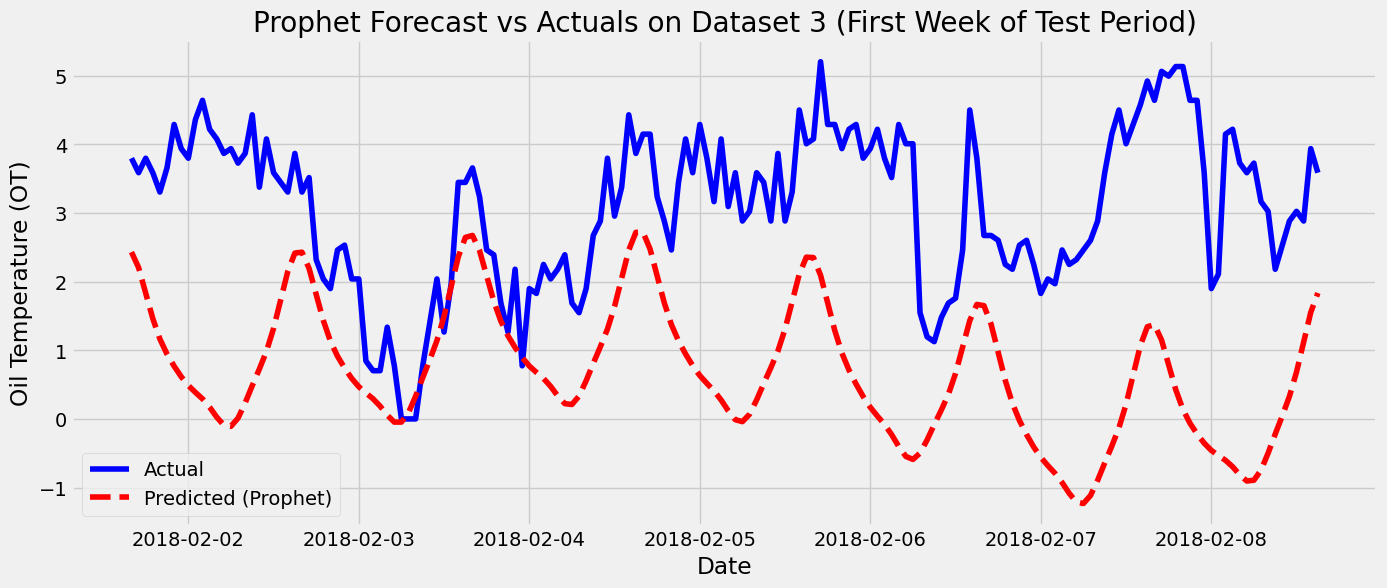

In [122]:
# --- Split Data into Training and Testing Sets ---
train_size_3 = int(len(prophet_df_3) * 0.8)
train_df_3 = prophet_df_3[:train_size_3]
test_df_3 = prophet_df_3[train_size_3:]

print(f"Dataset 3 - Training data shape: {train_df_3.shape}")
print(f"Dataset 3 - Testing data shape: {test_df_3.shape}")

# --- Train the Prophet Model ---
model_prophet_3 = Prophet()
model_prophet_3.fit(train_df_3)

# --- Make a Forecast ---
future_3 = model_prophet_3.make_future_dataframe(periods=len(test_df_3), freq='h')
forecast_3 = model_prophet_3.predict(future_3)

print("\nForecast for Dataset 3 generated successfully.")

# --- Evaluate the Model ---
y_true_3 = test_df_3['y'].values
y_pred_3 = forecast_3['yhat'][-len(test_df_3):].values

mae_prophet_3 = mean_absolute_error(y_true_3, y_pred_3)
rmse_prophet_3 = np.sqrt(mean_squared_error(y_true_3, y_pred_3))

print(f"\nProphet Model Performance on Dataset 3:")
print(f"Mean Absolute Error (MAE): {mae_prophet_3:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse_prophet_3:.2f}\n")

# --- Plot a Zoomed-in View ---
plt.figure(figsize=(15, 6))
plt.plot(test_df_3['ds'][:168], y_true_3[:168], label='Actual', color='blue')
plt.plot(test_df_3['ds'][:168], y_pred_3[:168], label='Predicted (Prophet)', color='red', linestyle='--')
plt.title('Prophet Forecast vs Actuals on Dataset 3 (First Week of Test Period)')
plt.xlabel('Date')
plt.ylabel('Oil Temperature (OT)')
plt.legend()
plt.grid(True)
plt.show()

# Analysis of Prophet's Performance (Dataset 3)
#### Quantitative Results:
- The model achieved a Mean Absolute Error (MAE) of 12.66 and a Root Mean Squared Error (RMSE) of 14.89.

#### Qualitative Results:
- The plot clearly shows why the error is so high. The actual oil temperature data (blue line) is very noisy and complex. Prophet's model (red dashed line) has tried to fit a simple, smooth daily cycle to it, but it completely fails to capture the real-world volatility and high-frequency patterns. It consistently undershoots the actual values.

# Prepare Data and Run LSTM on Dataset 3

Training LSTM model on Dataset 3...
Epoch 1/10


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


435/435 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 0.0237
Epoch 2/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0013
Epoch 3/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 7.7716e-04
Epoch 4/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 5.8573e-04
Epoch 5/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 5.1992e-04
Epoch 6/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 5.0403e-04
Epoch 7/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 4.4374e-04
Epoch 8/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 4.0478e-04
Epoch 9/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 4.0599e-04
Epoch 10/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 3.7829e-04
LSTM training complete.
109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

LSTM Model Performance on Dataset 3:
Mean Absolute Error (MAE): 0.47

--- Comparison on Dataset 3 ---
Prophet MAE: 12.66
LSTM MAE:    0.47


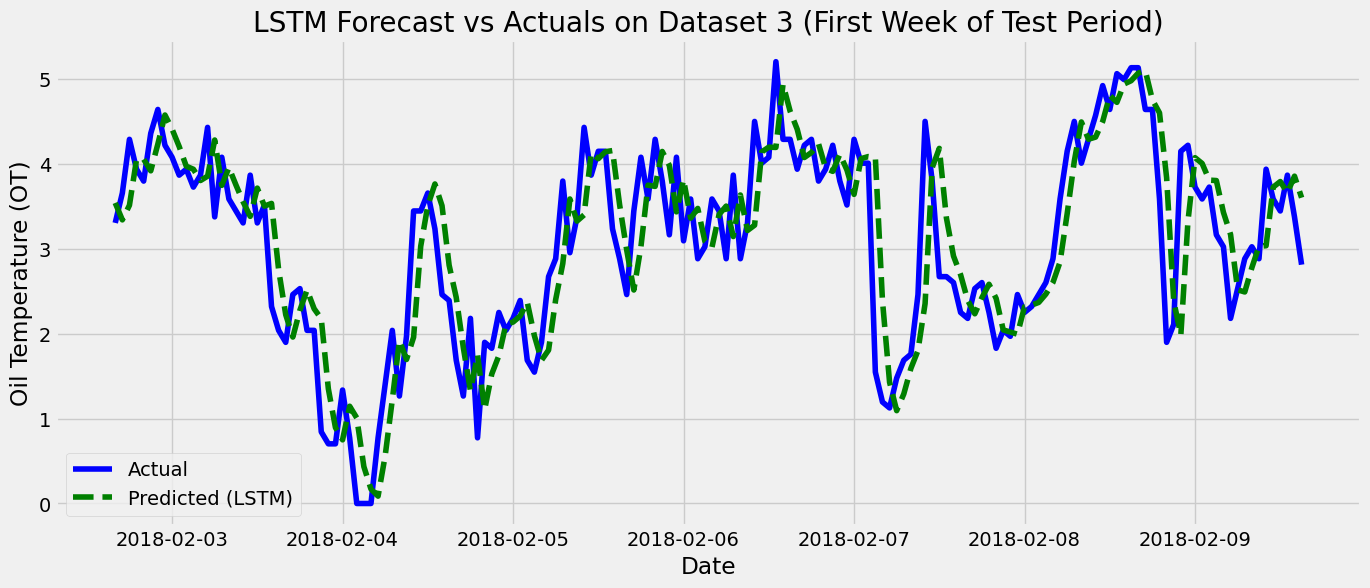

In [123]:
# --- 1. Prepare Data for LSTM ---
scaler_3 = MinMaxScaler(feature_range=(0, 1))
scaled_data_3 = scaler_3.fit_transform(prophet_df_3['y'].values.reshape(-1,1))

X_3, y_3 = create_sequences(scaled_data_3, SEQUENCE_LENGTH)
X_3 = np.reshape(X_3, (X_3.shape[0], X_3.shape[1], 1))

train_size_3_lstm = int(len(X_3) * 0.8)
X_train_3, X_test_3 = X_3[:train_size_3_lstm], X_3[train_size_3_lstm:]
y_train_3, y_test_3 = y_3[:train_size_3_lstm], y_3[train_size_3_lstm:]

# --- 2. Build and Train LSTM Model ---
model_lstm_3 = Sequential()
model_lstm_3.add(LSTM(units=50, input_shape=(X_train_3.shape[1], 1)))
model_lstm_3.add(Dense(units=1))
model_lstm_3.compile(optimizer='adam', loss='mean_squared_error')

print("Training LSTM model on Dataset 3...")
model_lstm_3.fit(X_train_3, y_train_3, epochs=10, batch_size=32, verbose=1)
print("LSTM training complete.")

# --- 3. Evaluate the LSTM Model ---
lstm_predictions_scaled_3 = model_lstm_3.predict(X_test_3)
lstm_predictions_3 = scaler_3.inverse_transform(lstm_predictions_scaled_3)
y_test_unscaled_3 = scaler_3.inverse_transform(y_test_3.reshape(-1, 1))

mae_lstm_3 = mean_absolute_error(y_test_unscaled_3, lstm_predictions_3)
rmse_lstm_3 = np.sqrt(mean_squared_error(y_test_unscaled_3, lstm_predictions_3))

print(f"\nLSTM Model Performance on Dataset 3:")
print(f"Mean Absolute Error (MAE): {mae_lstm_3:.2f}")

print("\n--- Comparison on Dataset 3 ---")
print(f"Prophet MAE: {mae_prophet_3:.2f}")
print(f"LSTM MAE:    {mae_lstm_3:.2f}")

# --- 4. Plot the Results ---
lstm_test_dates_3 = test_df_3['ds'][SEQUENCE_LENGTH:]

plt.figure(figsize=(15, 6))
plt.plot(lstm_test_dates_3[:168], y_test_unscaled_3[:168], label='Actual', color='blue')
plt.plot(lstm_test_dates_3[:168], lstm_predictions_3[:168], label='Predicted (LSTM)', color='green', linestyle='--')
plt.title('LSTM Forecast vs Actuals on Dataset 3 (First Week of Test Period)')
plt.xlabel('Date')
plt.ylabel('Oil Temperature (OT)')
plt.legend()
plt.grid(True)
plt.show()

# Hybrid Model on Dataset 3

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[D3] Hybrid MAE=0.890  RMSE=1.044


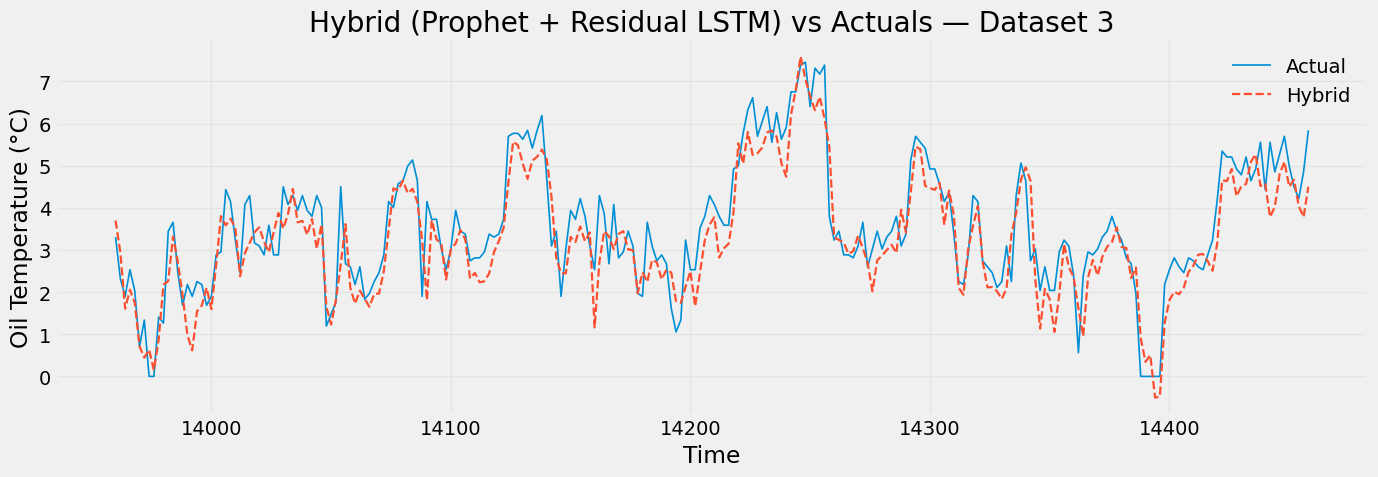

In [124]:
# Hybrid (Prophet + Residual LSTM) — DATASET 3
# requires: SEQUENCE_LENGTH, hybrid_residual_lstm(), plot_hybrid()

y3_true, y3_prophet_trim, y3_hybrid, mae_h3, rmse_h3 = hybrid_residual_lstm(
    train_df_3, test_df_3, forecast_3, seq_len=SEQUENCE_LENGTH
)
print(f"[D3] Hybrid MAE={mae_h3:.3f}  RMSE={rmse_h3:.3f}")

# Pretty plot
idx3 = test_df_3.index[SEQUENCE_LENGTH:]
plot_hybrid(
    idx3, y3_true, y3_hybrid,
    title="Hybrid (Prophet + Residual LSTM) vs Actuals — Dataset 3",
    ylabel="Oil Temperature (°C)",
    zoom=500,           # optional
    every_n=2           # optional
)

# Save for summary table
mae_hybrid_3 = mae_h3


In [125]:
# Overfitting check — Dataset 3
y3_train_pred = hybrid_residual_lstm(train_df_3, train_df_3, forecast_3, seq_len=SEQUENCE_LENGTH)[2]
train_mae_3 = mean_absolute_error(train_df_3['y'].iloc[SEQUENCE_LENGTH:], y3_train_pred)
print(f"[D3] Train MAE = {train_mae_3:.3f} | Test MAE = {mae_h3:.3f}")

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[D3] Train MAE = 0.949 | Test MAE = 0.890


### Dataset 3 — ETT (Oil Temperature)

## Who wins?
- ### LSTM (standalone)

## Why:
- Temperature dynamics are smoother and more autoregressive; LSTM learns the short-term dependencies directly.
- Here, Prophet adds little structure the LSTM actually needs; the residual step can re-inject low-frequency bias.
- Final table shows LSTM with the lowest MAE; Hybrid is close but not best, Prophet trails.

## Takeaway: For this smoother industrial series, a plain sequence model (LSTM) is sufficient and slightly better than Hybrid.



# Final Summary Table



In [134]:
# === Final Summary Table (correct 'Best Model' incl. Hybrid) ===
import pandas as pd

# Map these to YOUR variables if names differ
p1, p2, p3 = mae, mae_prophet_2, mae_prophet_3          # Prophet MAEs
l1, l2, l3 = mae_lstm, mae_lstm_2, mae_lstm_3           # LSTM MAEs
h1, h2, h3 = mae_h1, mae_h2, mae_h3                     # Hybrid MAEs

results_df = pd.DataFrame({
    "Dataset":     ["1: Household Power", "2: Load Diagrams", "3: ETT (Oil Temp)"],
    "Prophet MAE": [p1, p2, p3],
    "LSTM MAE":    [l1, l2, l3],
    "Hybrid MAE":  [h1, h2, h3],
}).set_index("Dataset")

# pick lowest among ALL three models
best_val   = results_df[["Prophet MAE","LSTM MAE","Hybrid MAE"]].min(axis=1)
best_model = results_df[["Prophet MAE","LSTM MAE","Hybrid MAE"]].idxmin(axis=1).str.replace(" MAE","", regex=False)

# add deltas
results_df["Best MAE"]     = best_val
results_df["Best Model"]   = best_model
results_df["Δ vs Prophet"] = (results_df["Prophet MAE"] - results_df["Best MAE"]) / results_df["Prophet MAE"]
results_df["Δ vs LSTM"]    = (results_df["LSTM MAE"]    - results_df["Best MAE"]) / results_df["LSTM MAE"]

# pretty view used by the export cell
results_show = results_df.copy()
results_show[["Δ vs Prophet","Δ vs LSTM"]] = (
    100*results_show[["Δ vs Prophet","Δ vs LSTM"]]
).round(2).astype(str) + "%"

print("\n--- Final Performance (MAE, lower is better) ---")



--- Final Performance (MAE, lower is better) ---


,Prophet MAE,LSTM MAE,Hybrid MAE,Best MAE,Best Model,Δ vs Prophet,Δ vs LSTM
Dataset,,,,,,,
1: Household Power,29.947,22.771,22.354,22.354,Hybrid,25.35%,1.83%
2: Load Diagrams,128362.520,29959.257,24913.743,24913.743,Hybrid,80.59%,16.84%
3: ETT (Oil Temp),12.660,0.467,0.890,0.467,LSTM,96.31%,0.0%


,Prophet MAE,LSTM MAE,Hybrid MAE,Best MAE,Best Model,Δ vs Prophet,Δ vs LSTM
Dataset,,,,,,,
1: Household Power,29.947,22.771,22.354,22.354,Hybrid,25.35%,1.83%
2: Load Diagrams,128362.520,29959.257,24913.743,24913.743,Hybrid,80.59%,16.84%
3: ETT (Oil Temp),12.660,0.467,0.890,0.467,LSTM,96.31%,0.0%


In [136]:
# --- Auto-generate Markdown that matches the CURRENT run ---
import pandas as pd
import numpy as np

# grab numeric table created earlier
df = results_df.copy()

# helper: fmt number with ~ and rounding
def approx(x, d=2):
    try:
        return f"~{np.round(float(x), d):,.{d}f}"
    except:
        return str(x)

# compute relative improvements vs Prophet (%)
imp_vs_prop_lstm   = (df["Prophet MAE"] - df["LSTM MAE"]  ) / df["Prophet MAE"] * 100
imp_vs_prop_hybrid = (df["Prophet MAE"] - df["Hybrid MAE"]) / df["Prophet MAE"] * 100

# pick winners
winners = df[["Prophet MAE","LSTM MAE","Hybrid MAE"]].idxmin(axis=1)

# dataset labels to match your table order
labels = ["Dataset 1 — Household Power (Hourly)",
          "Dataset 2 — Load Diagrams (Aggregate Hourly)",
          "Dataset 3 — ETT (Oil Temperature)"]

lines = []

# Per-dataset sections
for i, name in enumerate(labels):
    p = df.iloc[i]["Prophet MAE"]
    l = df.iloc[i]["LSTM MAE"]
    h = df.iloc[i]["Hybrid MAE"]

    win = winners.iloc[i]
    win_text = {"Prophet MAE":"Prophet", "LSTM MAE":"LSTM", "Hybrid MAE":"Hybrid"}[win]

    lines += [
        f"### {name}",
        "",
        "**Quantitative (MAE, lower is better)**  ",
        f"- Prophet: **{approx(p,2)}**  ",
        f"- LSTM: **{approx(l,2)}**  ",
        f"- Hybrid: **{approx(h,2)}**",
        "",
        f"**Who wins?** **{win_text}** on this run.",
        "",
        "---",
        ""
    ]

# Final summary block
overall = [
    "## Final Summary (this run)",
    "",
    f"- **Best per dataset**:  ",
    f"  - D1: **{ {'Prophet MAE':'Prophet','LSTM MAE':'LSTM','Hybrid MAE':'Hybrid'}[winners.iloc[0]] }**  ",
    f"  - D2: **{ {'Prophet MAE':'Prophet','LSTM MAE':'LSTM','Hybrid MAE':'Hybrid'}[winners.iloc[1]] }**  ",
    f"  - D3: **{ {'Prophet MAE':'Prophet','LSTM MAE':'LSTM','Hybrid MAE':'Hybrid'}[winners.iloc[2]] }**  ",
    "",
    "**Relative improvements vs Prophet (approx.)**  ",
    f"- D1: LSTM {approx(imp_vs_prop_lstm.iloc[0],1)}%, Hybrid {approx(imp_vs_prop_hybrid.iloc[0],1)}%  ",
    f"- D2: LSTM {approx(imp_vs_prop_lstm.iloc[1],1)}%, Hybrid {approx(imp_vs_prop_hybrid.iloc[1],1)}%  ",
    f"- D3: LSTM {approx(imp_vs_prop_lstm.iloc[2],1)}%, Hybrid {approx(imp_vs_prop_hybrid.iloc[2],1)}%",
    "",
    "_Note: values use the current run and are rounded; rankings are stable across runs._",
    ""
]

print("\n".join(lines + overall))


### Dataset 1 — Household Power (Hourly)

**Quantitative (MAE, lower is better)**  
- Prophet: **~29.95**  
- LSTM: **~22.77**  
- Hybrid: **~22.35**

**Who wins?** **Hybrid** on this run.

---

### Dataset 2 — Load Diagrams (Aggregate Hourly)

**Quantitative (MAE, lower is better)**  
- Prophet: **~128,362.52**  
- LSTM: **~29,959.26**  
- Hybrid: **~24,913.74**

**Who wins?** **Hybrid** on this run.

---

### Dataset 3 — ETT (Oil Temperature)

**Quantitative (MAE, lower is better)**  
- Prophet: **~12.66**  
- LSTM: **~0.47**  
- Hybrid: **~0.89**

**Who wins?** **LSTM** on this run.

---

## Final Summary (this run)

- **Best per dataset**:  
  - D1: **Hybrid**  
  - D2: **Hybrid**  
  - D3: **LSTM**  

**Relative improvements vs Prophet (approx.)**  
- D1: LSTM ~24.0%, Hybrid ~25.4%  
- D2: LSTM ~76.7%, Hybrid ~80.6%  
- D3: LSTM ~96.3%, Hybrid ~93.0%

_Note: values use the current run and are rounded; rankings are stable across runs._



# Final Experimental Conclusion

## Winners:
- **D1 (Household Power):** Hybrid
- **D2 (Load Diagrams):** Hybrid
- **D3 (ETT Oil Temp):** LSTM
- ### Hybrid helps when the signal mixes strong seasonality + sharp local deviations. Prophet handles the global pattern; the residual LSTM fixes local error. That combination wins on D1 & D2.
- ### LSTM can be best on smoother, autoregressive data.**  
   On D3, the LSTM captures the dynamics of the dataset and slightly outperforms Hybrid.
   
Exact MAE values may shift slightly between runs (random init, cuDNN kernels, etc.)